# [실습] Agent의 Planning ReAct 알아보기

`ToolNode`와 `ToolCondition`을 통해 툴을 실행하는 에이전트 구조를 만들어 보았습니다.

이 구조는 랭그래프에서 ReAct 에이전트라는 형태로 구현이 되어 있습니다.

In [ ]:
!pip install --upgrade langgraph langchain langchain_google_genai langchain_community langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.5
    Uninstalling langchain-text-splitters-0.3.5:
      Successfully uni

API 키와 LLM을 설정합니다.

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = ''

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    rate_limiter=rate_limiter
)

<ipython-input-3-4e191f275e11>:9: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


LLM에서 사용할 툴을 설정합니다.

In [ ]:
# Tavily API
os.environ['TAVILY_API_KEY'] = ''


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import random

tavily_search = TavilySearchResults(
    max_results=5)

@tool
def current_date() -> str:
    "현재 날짜를 %y-%m-%d 형식으로 반환합니다."
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")


@tool
def counsel(problem:str) -> str: # 나중에는 LLM 기반의 모듈이나, 개별 에이전트로 처리 가능
    "고민에 대한 답을 예/아니오로 얻습니다."
    if random.random()>=0.5:
        return '네!'
    else:
        return '아니오.'

print(current_date.invoke({}))
print(counsel.invoke({'problem':'아무 고민'}))




2025-02-10
네!


이번에는 새로운 툴을 추가해 보겠습니다.   
`Python_REPL`은 파이썬 쉘을 이용해서 코드를 실행하는 기능으로, ChatGPT의 코드 인터프리터와 유사합니다.

In [ ]:
from langchain_experimental.tools.python.tool import PythonREPLTool

repl_tool = PythonREPLTool()
repl_tool.invoke("for i in range(10): print(i)")

'0\n1\n2\n3\n4\n5\n6\n7\n8\n9\n'

React Agent는 `langgraph.prebuilt` 에서 바로 실행할 수 있습니다.

In [ ]:
from langgraph.prebuilt import create_react_agent

tools = [tavily_search, current_date, counsel, repl_tool]

graph = create_react_agent(llm, tools=tools)

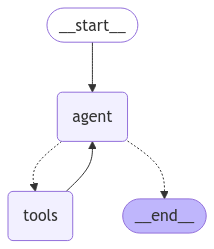

In [ ]:
graph

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

graph.invoke({'messages':[HumanMessage(content="오늘 운동을 빠질지 말지 고민이에요.")]})

{'messages': [HumanMessage(content='오늘 운동을 빠질지 말지 고민이에요.', additional_kwargs={}, response_metadata={}, id='2c6f5cd0-ea5f-4466-9ef1-156e1fa5a931'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'counsel', 'arguments': '{"problem": "\\uc624\\ub298 \\uc6b4\\ub3d9\\uc744 \\ube60\\uc9c8\\uc9c0 \\ub9d0\\uc9c0 \\uace0\\ubbfc"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8a8bb8b3-44e8-4a0f-8a06-179523a6facd-0', tool_calls=[{'name': 'counsel', 'args': {'problem': '오늘 운동을 빠질지 말지 고민'}, 'id': 'a61ea878-01f0-4c4f-b2d7-95c6cb11ccfd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 15, 'total_tokens': 165, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='아니오.', name='counsel', id='3b7a9174-312e-401d-b035-b95082fa8f77', tool_call_id='a61ea878-01f0-4c4f-b2d7-95c6cb11ccfd'),
  AIMessage(content='운동을 빠지지 마세요.', additional_kwargs={}, respons

In [ ]:
for data in graph.stream(
    {'messages':[
        HumanMessage(content='''
오늘 날짜 확인해서 txt 파일로 저장해, 파일 이름은 날짜.txt로 하고,
파일 시스템 접근이 필요한 경우, PythonREPL 코드를 짜서 실행하면 돼. ''')]},
    stream_mode='updates'):
    print(data)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'current_date', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b479f437-6dbc-4533-91da-2746ca83c4b9-0', tool_calls=[{'name': 'current_date', 'args': {}, 'id': '10d00da1-3433-4376-b5ab-0abcd6236b1d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 182, 'output_tokens': 3, 'total_tokens': 185, 'input_token_details': {'cache_read': 0}})]}}
{'tools': {'messages': [ToolMessage(content='2025-02-10', name='current_date', id='3f7c24bc-ad4e-4207-9b24-65002c1713c1', tool_call_id='10d00da1-3433-4376-b5ab-0abcd6236b1d')]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'Python_REPL', 'arguments': '{"query": "file_name = \'2025-02-10.txt\'\\nfile = open(file_name, \'w\')\\nfile.write(\'2025-02-10\')\\nfile.close()\\n"}'}}, response_metadata={'prompt_

이번에는 Tool Node, ToolCondition 등의 Prebuilt 없이 구현해 보겠습니다.

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages : Annotated[list, add_messages]   # 메시지 맥락을 저장하는 리스트


In [ ]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(rate_limiter=<langchain_core.rate_limiters.InMemoryRateLimiter object at 0x7c039e455110>, model='models/gemini-2.0-flash-exp', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7c039e3d0210>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'current_date', 'description': '현재 날짜를 %y-%m-%d 형식으로 반환합니다.', 'parameters': {'properties': {}, 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'counse

In [ ]:
from langchain_core.messages import ToolMessage

tool_list = {tool.name: tool for tool in tools}
# tool 목록 dict로 생성

def tool_node(state):
    tool_outputs = []
    tool_call_msgs = state['messages'][-1]
    # 마지막 메시지: 툴 콜링 메시지

    for tool_call in tool_call_msgs.tool_calls:
    # 여러 개의 툴 콜이 필요한 경우를 고려해 for로 표시
        tool_exec = tool_list[tool_call['name']]
        # 실제 함수 찾기
        tool_result = tool_exec.invoke(tool_call)
        # tool 실행 결과 얻기 (결과는 ToolMessage 타입: 1번 실습 참고)
        tool_outputs.append(tool_result)

    return {'messages': tool_outputs}

def agent(state):

    # system_prompt = SystemMessage("주어진 툴을 사용하여, 사용자의 질문에 답하세요.")

    # ReAct 목적에 충실한 버전
    system_prompt = SystemMessage("""주어진 툴을 사용하여, 사용자의 질문에 답하세요.
툴을 실행하기 전, 직전까지의 결과의 의미를 파악하고 맥락에 맞게 다음 툴을 실행하기 위한 Planning Step을 메시지에 포함해 출력하세요.
파일 시스템 접근은 파이썬 코드를 실행하여 처리하세요.
에러가 발생하면, 전략을 바꿔 다시 실행하세요.""")


    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    # Tool Calling이 필요한 경우와 필요하지 않은 경우를 구분할할 필요
    return {'messages': response}

def tool_needed(state):

    last_msg = state['messages'][-1]
    if last_msg.tool_calls: # 툴 콜링이 필요하면
        return "continue"
    else:
        return "finish"

In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("agent", agent)
builder.add_node("tools", tool_node)

builder.add_edge(START, 'agent'),
builder.add_conditional_edges("agent",
                              tool_needed,
                               {"continue": "tools","finish": END})
builder.add_edge("tools", "agent")

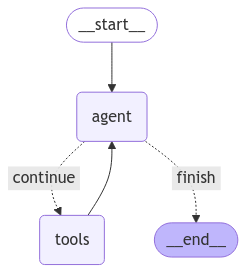

In [ ]:
graph = builder.compile()
graph

In [ ]:
response = graph.invoke({'messages':[HumanMessage(content="패스트캠퍼스 랭그래프 과정 검색해서 소개해줘.")]})
response

{'messages': [HumanMessage(content='패스트캠퍼스 랭그래프 과정 검색해서 소개해줘.', additional_kwargs={}, response_metadata={}, id='a261db0f-7c08-4d8e-9c20-4e7c98b5c27a'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ud328\\uc2a4\\ud2b8\\ucea0\\ud37c\\uc2a4 \\ub7ad\\uadf8\\ub798\\ud504 \\uacfc\\uc815"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-71083e13-698e-4629-b523-ebaba13a1776-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '패스트캠퍼스 랭그래프 과정'}, 'id': '91c803af-19c8-4d7c-bc79-43478cb937bb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 248, 'output_tokens': 21, 'total_tokens': 269, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"url": "https://fastcampus.co.kr/categories", "content": "랭그래프로 한번에 완성하는 복잡한 RAG와 Agent. 약 20시간사전지식 필요 · 강의 대표이미지. 10+. 딥러닝 · 파인튜닝과 RAG로 완성하는 맞춤형 LL

In [ ]:
for data in graph.stream(
    {'messages':[HumanMessage(content='''
    오늘 날짜 확인해서 txt 파일로 저장해, 파일 이름은 날짜.txt로 해.''')]}, stream_mode='updates'):
    print(data)
    print('----------')


{'agent': {'messages': AIMessage(content='먼저 오늘 날짜를 알아내야 합니다. 그런 다음 해당 날짜를 사용하여 파일 이름으로 txt 파일을 만들고 날짜를 파일에 써야 합니다.', additional_kwargs={'function_call': {'name': 'current_date', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d53a6574-a556-4d16-91ac-a12a893df6ee-0', tool_calls=[{'name': 'current_date', 'args': {}, 'id': '7ca1dc51-bc1a-439a-941d-e22db1a267fd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 253, 'output_tokens': 45, 'total_tokens': 298, 'input_token_details': {'cache_read': 0}})}}
----------
{'tools': {'messages': [ToolMessage(content='2025-02-10', name='current_date', id='82dae67b-f501-4e9e-b8fa-342d5eef8f68', tool_call_id='7ca1dc51-bc1a-439a-941d-e22db1a267fd')]}}
----------
{'agent': {'messages': AIMessage(content='현재 날짜를 얻었습니다. 이제 날짜를 사용하여 파일 이름을 만들고 txt 파일로 저장해야 합니다. 파일 시스템에 접근하려면 파이썬 쉘을 사용해야 합니다.', additional_kwargs={'function_call': {'name': 'Pyth